# Time series project

In [782]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import networkx as nx
from collections import deque, OrderedDict

Useful function to calculate Laplacian and its conjugate.

In [783]:
def edge_list(p: int):
    """
    Returns list of (i,j) pairs with i>j in a fixed order.
    Length = p*(p-1)//2
    """
    edges = []
    for j in range(p):
        for i in range(j+1, p):
            edges.append((i, j))

    edges = np.array(edges)
    return edges

def L_operator(w: np.ndarray, p: int, edges=None) -> np.ndarray:
    """
    Laplacian operator L: 
    Builds Theta = Lw such that:
      Theta_ij = -w_k for (i,j) edge with i>j
      Theta is symmetric
      Theta_ii = -sum_{j!=i} Theta_ij  (so rows sum to 0)
    Matches Definition of Laplacian set S_Theta and operator L.  (paper Sec 3.1)

    See the paper for more information, specifically [page 13] !
    """

    if edges is None:
        edges = edge_list(p)
    m = p * (p - 1) // 2
    assert w.shape == (m,), f"w must have shape ({m},), got {w.shape}"

    Theta = np.zeros((p, p))
    for k, (i, j) in enumerate(edges):

        Theta[i, j] = -w[k]
        Theta[j, i] = -w[k]

    Theta[np.diag_indices(p)] = -Theta.sum(axis=1)

    return Theta

def L_adjoint(Y: np.ndarray, p: int, edges=None) -> np.ndarray:

    """
    Adjoint operator L*: 
    For each edge (i>j), returns:
      [L*Y]_k = Y_ii - Y_ij - Y_ji + Y_jj

    See paper for adjoint formula, specifically [page 14]
    """

    if edges is None:
        edges = edge_list(p)

    assert Y.shape == (p, p), f"Y must have shape ({p},{p}), got {Y.shape}"

    m = p * (p - 1) // 2
    out = np.zeros(m)

    for k, (i, j) in enumerate(edges):
        out[k] = Y[i, i] - Y[i, j] - Y[j, i] + Y[j, j]

    return out

def adjacency_from_theta(theta: np.ndarray):
    """
    For Laplacian Theta:
      off-diagonals are negative weights: Theta[i,j] = -w_ij
    """
    W = np.maximum(-theta, 0.0)
    thr = np.quantile(W[W > 0], 0.90)
    print(f"The threshold is: {thr}") 
    np.fill_diagonal(W, 0.0)
    W[W < thr] = 0.0
    return W

Test the correctess of the Adjoint and the Laplacian Matrix

In [784]:
p = 100
edges = edge_list(p)

m = p*(p-1)//2
w = np.arange(1, m+1)
Theta = L_operator(w, p, edges)
Y = np.random.randn(p, p)

left = np.sum(Theta * Y)  
right = np.dot(w, L_adjoint(Y, p, edges))
print("adjoint error:", np.isclose(left - right, 0), np.abs(left - right))

adjoint error: True 2.3283064365386963e-10


We can see that the scalar product is preserved, so the adjoint formula is correct. This part here plots the connected compoennt and shows the eigen values representing the numbe of connected compoenents.

Connected components (networkx): 3
Connected components (spectral): 3
Smallest eigenvalues: [-3.99680289e-15  7.95981194e-15  1.94323724e-14  1.73060156e+00
  2.05637522e+00  2.29885221e+00  2.45015368e+00  2.48869431e+00
  2.59987204e+00  2.92093989e+00]


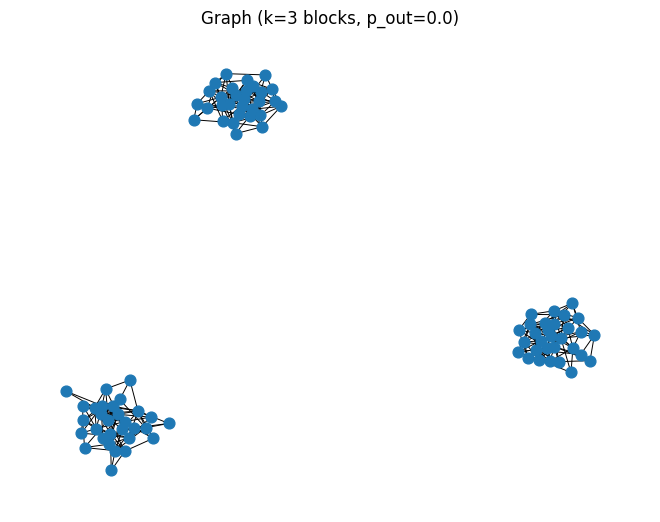

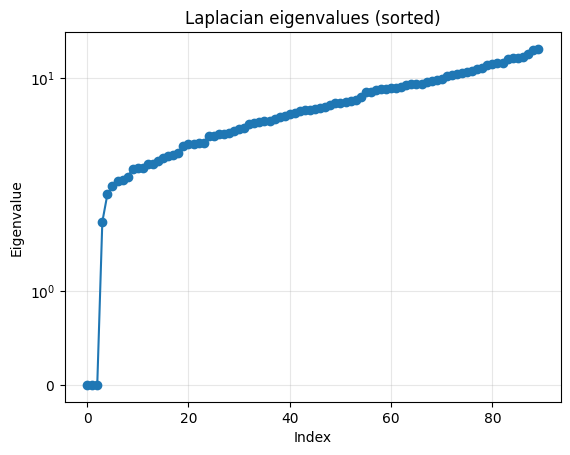

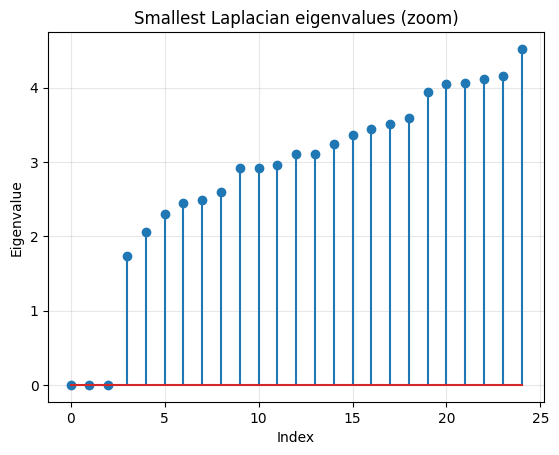

In [785]:
def laplacian_from_W(W: np.ndarray):
    """ Laplacian L = D - W.
    
        W : Adjacency matrix of the graph 
    """
    D = np.diag(W.sum(axis=1))
    return D - W

def normalized_laplacian_from_W(W: np.ndarray):

    """Normalized Laplacian L_sym = I - D^{-1/2} W D^{-1/2}."""
    
    d = W.sum(axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))

    I = np.eye(W.shape[0])
    # Formula in tp altegrad
    return I - D_inv_sqrt @ W @ D_inv_sqrt

def count_components_from_eigs(eigs, tol=1e-8):
    """#components = multiplicity of eigenvalue 0 (within tolerance)."""
    return int(np.sum(eigs < tol))

# -----------------------------
# Generate a graph with k connected components
# -----------------------------
n_per = 30
k = 3
p_in = 0.25   
p_out = 0.0   

sizes = [n_per] * k
P = np.full((k, k), p_out)
np.fill_diagonal(P, p_in)

G = nx.stochastic_block_model(sizes, P)
W = nx.to_numpy_array(G, weight=None)
np.fill_diagonal(W, 0.0)

# -----------------------------
# Laplacian and eigenvalues
# -----------------------------
L = laplacian_from_W(W) 

eigs = np.linalg.eigvalsh(L)  
num_cc = nx.number_connected_components(G)
num_cc_from_spec = count_components_from_eigs(eigs, tol=1e-8)

print("Connected components (networkx):", num_cc)
print("Connected components (spectral):", num_cc_from_spec)
print("Smallest eigenvalues:", eigs[:10])

# -----------------------------
# Plot graph and eigenvalues
# -----------------------------
plt.figure()
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
plt.plot(eigs, marker="o")
plt.yscale("symlog")  
plt.title("Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
m = min(25, len(eigs))
plt.stem(range(m), eigs[:m])
plt.title("Smallest Laplacian eigenvalues (zoom)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()


SGL Algorithm, implemting the first algorithm of lambda and the correspinding second for updating the eigen values.

In [787]:
def update_lambda(d, beta, c1, c2):
    
    d = np.asarray(d, dtype=float)
    q = d.size
    if q == 0:
        return d.copy(), np.empty((0, 0)), np.array([])

    def g(x):
        return 0.5 * (x + np.sqrt(x * x + 4.0 / beta))

    def objective(lam):
        return -np.sum(np.log(lam)) + 0.5 * beta * (np.linalg.norm(lam - d) ** 2)

    lam_values = []
    obj_values = []

    def log_full_lambda(mid_raw, left, right):
        lam_t = np.empty(q, dtype=float)
        lam_t[:left] = c1
        lam_t[left:right] = mid_raw
        lam_t[right:] = c2
        lam_t = np.clip(lam_t, c1, c2)
        lam_values.append(lam_t.copy())
        obj_values.append(objective(lam_t))

    def pav_with_history(d_seg, left, right):

        blocks = []  # [start, end, sum, count, lambda=g(mean)]
        
        for i, val in enumerate(d_seg):
        
            blocks.append([i, i, float(val), 1, g(float(val))])

            # log current mid_raw from blocks
            mid = np.empty(len(d_seg), dtype=float)
            for a, b, s, c, lamv in blocks:
                mid[a:b+1] = lamv
        
            log_full_lambda(mid, left, right)

            while len(blocks) >= 2 and blocks[-2][4] > blocks[-1][4]:
                
                b2 = blocks.pop()
                b1 = blocks.pop()
                s = b1[2] + b2[2]
                c = b1[3] + b2[3]
                
                blocks.append([b1[0], b2[1], s, c, g(s / c)])

                # log after each merge
                
                mid = np.empty(len(d_seg), dtype=float)
                
                for a, b, s, c, lamv in blocks:
                    mid[a:b+1] = lamv
                
                log_full_lambda(mid, left, right)

        out = np.empty(len(d_seg), dtype=float)
        
        for a, b, s, c, lamv in blocks:
            out[a:b+1] = lamv
        
        return out

    left, right = 0, q
    
    while True:
        
        mid_raw = pav_with_history(d[left:right], left, right)

        low = np.where(mid_raw < c1)[0]
        
        if low.size > 0:
            left = left + low.max() + 1
            continue

        high = np.where(mid_raw > c2)[0]
        
        if high.size > 0:
            right = left + high.min()
            continue

        lam_final = np.empty(q, dtype=float)
        lam_final[:left] = c1
        lam_final[left:right] = mid_raw
        lam_final[right:] = c2
        lam_final = np.clip(lam_final, c1, c2)

        return lam_final, np.vstack(lam_values), np.array(obj_values)


Testing the correctness of the algorithm

(26,) (20,) (26, 20)


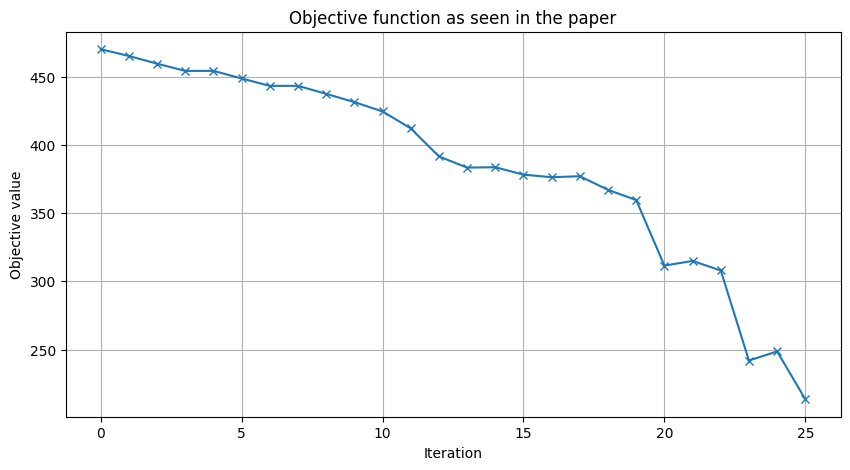

In [790]:
Y = np.random.randn(20, 20)
evals, U = np.linalg.eigh(Y)
D = U.T @ Y @ U
d = np.diag(D)
beta = 10

lam, lam_values, obj_values = update_lambda(d, beta = beta, c1 = 1e-4, c2 =  10)
print(obj_values.shape, lam.shape, lam_values.shape)

plt.figure(figsize=(10, 5))
plt.plot(obj_values, marker="x")
plt.xlabel("Iteration")
plt.ylabel("Objective value")
plt.title("Objective function as seen in the paper")
plt.grid()
plt.show()

We do get sorted values of the eigen vals that minimize the sum.


### SGL

In [791]:
def phi_log(w, eps : float):
    return np.log(eps + w)

def sgl_objective(S: np.ndarray,
                  Lw: np.ndarray,
                  w: np.ndarray,
                  U: np.ndarray,
                  lam: np.ndarray,
                  alpha: float,
                  beta: float,
                  eps: float,
                  phi) -> float:
    """
    F(w,lam,U) =
      - log gdet(Diag(lam)) + tr(S Lw) + alpha * sum_i phi(w_i)
      + (beta/2) * ||Lw - U Diag(lam) U^T||_F^2
    """
    lam = np.asarray(lam, dtype=float)
    if np.any(lam <= 0):
        return np.inf  

    term_gdet = -np.sum(np.log(lam))                 
    term_trace = float(np.trace(S @ Lw))             
    term_sparse = float(alpha * np.sum(phi(w, eps)))      

    B = U @ np.diag(lam) @ U.T
    term_pen = 0.5 * beta * (np.linalg.norm(Lw - B, ord="fro") ** 2)

    return term_gdet + term_trace + term_sparse + term_pen

In [792]:
def sgl(S: np.ndarray,
        k: int,
        alpha: float = 1e-3,
        beta: float = 10.0,
        eps: float = 1e-5,
        c1: float = 1e-5,
        c2: float = 1e4,
        w0: np.ndarray | None = None,
        tol = 1e-5,
        patience = 5,
        l1 = 2.0):
    
    """
    Structured Graph Learning via Laplacian spectral constraints (SGL), Algorithm 2. :contentReference[oaicite:9]{index=9}

    Inputs (match paper):
      - S: sample covariance matrix (SCM)
      - k: number of connected components (k>=1), so q = p-k non-zero eigenvalues
      - c1, c2: bounds for non-zero Laplacian eigenvalues
      - beta: penalty parameter in relaxation
      - alpha: sparsity weight for reweighted l1 via log(eps + w_i)
      - eps: small positive number in log(eps + w_i)
      - w0: initialization for edge weights (nonnegative), length p(p-1)/2
      - stopping: relative change in w

    Returns:
      Theta: learned Laplacian matrix (p x p)
      w, U, lam: final iterates
    """
    
    step = 0
    best = np.inf
    patience_break = 0

    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    assert S.shape == (p, p)
    assert 0 <= k < p

    edges = edge_list(p)
    m = len(edges)

    if w0 is None:
        w = 0.1 * np.ones(m, dtype=float)
        
    else:
        w = np.asarray(w0, dtype=float).copy()
        assert w.shape == (m,)
        w = np.maximum(w, 0.0)

    L1 = l1 * p
    obj_hist = []
    sgl_obj = []
    pen_hist = []

    # initialize Theta, U, lambda from current Theta
    
    Lw = L_operator(w, p, edges)
    _, evecs = np.linalg.eigh(Lw)  
    U = evecs[:, k:]

    d0 = np.diag(U.T @ Lw @ U).copy()
    lam, _, obj_values = update_lambda(d0, beta=beta, c1=c1, c2=c2)     
    obj_hist.append(obj_values[-1])

    while True: 
        
        w_old = w.copy()
        
        D = np.zeros(shape=(lam.shape[0], lam.shape[0]))
        np.fill_diagonal(D, lam)
      
        c = L_adjoint((U @ D @ U.T) - (1 / beta) * S, p, edges)

        Lw = L_operator(w, p, edges) 
        grad = L_adjoint(Lw, p, edges) - c + (alpha / beta) * (1 / (eps + w))

        w = np.maximum(w - (grad / L1), 0.0)

        Lw = L_operator(w, p, edges)
        _, evecs = np.linalg.eigh(Lw)  
        U = evecs[:, k:]               

        d = np.diag(U.T @ Lw @ U).copy()
        lam, _, obj_values = update_lambda(d, beta=beta, c1=c1, c2=c2)
        obj_sgl = sgl_objective(S, Lw, w, U, lam, alpha=alpha, beta=beta, eps=eps, phi=phi_log)
        
        obj_hist.append(obj_values[-1])
        sgl_obj.append(obj_sgl)
        pen_hist.append(np.linalg.norm(Lw - U @ np.diag(lam) @ U.T, ord="fro"))

        error = (np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12))

        if error < best :
            best = error
            patience_break = 0
            print(f"the best relative error is: {best}")

        elif error >= best :
            patience_break += 1

        if step % 10 == 0:
            print(f"the relative error is: {error}")

        if (np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12)) < tol or patience_break == patience:
            break
        
        step += 1

    Theta = L_operator(w, p, edges)
    print(f"The best final relative error is: {best}")
    
    return Theta, w, U, lam, np.array(obj_hist), np.array(sgl_obj), np.array(pen_hist)

Application to noisy graphs

In [821]:
p = 20
k_true = 4

sizes = [p // k_true] * k_true  
W_true = np.zeros((p, p), dtype=float)

start = 0
for sz in sizes:
    idx = np.arange(start, start + sz)

    A = np.ones((sz, sz), dtype=float)
    np.fill_diagonal(A, 0.0)

    W = np.random.uniform(0.0, 1.0, size=(sz, sz))
    W =  (W + W.T) / 2          
    np.fill_diagonal(W, 0.0)

    W_true[np.ix_(idx, idx)] = A * W
    start += sz

Theta_true = laplacian_from_W(W_true)

In [822]:
kappa=0.45
p_edge=0.35

M = (np.random.random((p, p)) < p_edge).astype(float)
M = np.triu(M, 1)
M = M + M.T

W_er = np.random.uniform(low = 0.0, high = kappa, size=(p, p))
W_er = (W_er + W_er.T) / 2
np.fill_diagonal(W_er, 0.0)

W_er = M * W_er
Theta_er = laplacian_from_W(W_er)

In [823]:
Theta_noisy = Theta_true + Theta_er

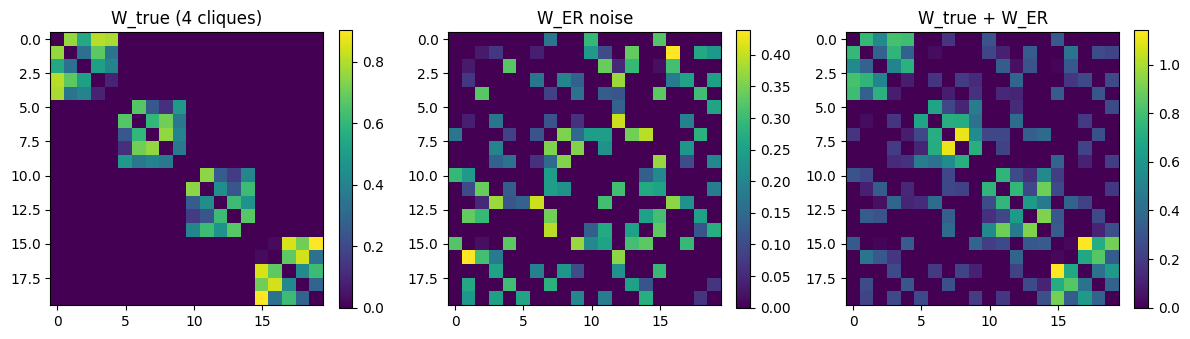

In [824]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(W_true)
plt.title("W_true (4 cliques)")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,2)
plt.imshow(W_er)
plt.title("W_ER noise")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,3)
plt.imshow(W_true + W_er)
plt.title("W_true + W_ER")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

We wish to learn W_true from W_noise. We first calculate the covariance matrix

In [825]:
n = 30 * p
Sigma = np.linalg.pinv(Theta_noisy)
X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)
Xc = X - X.mean(axis = 0, keepdims=True)
S_in = Xc.T @ Xc

In [826]:
Theta_hat, w_hat, U_hat, lam_hat, obj_values, sgl_obj, pen_hist = sgl(
        S=S_in,
        k=k_true,
        alpha=0.1,
        beta=400.0,
        eps=1e-2,
        c1=1e-5,
        c2=1e4,
        tol=1e-10,
        patience=np.inf,
        l1 = 2.0
    )

the best relative error is: 0.4504415631177535
the relative error is: 0.4504415631177535
the best relative error is: 0.4299005294574461
the best relative error is: 0.0
The best final relative error is: 0.0


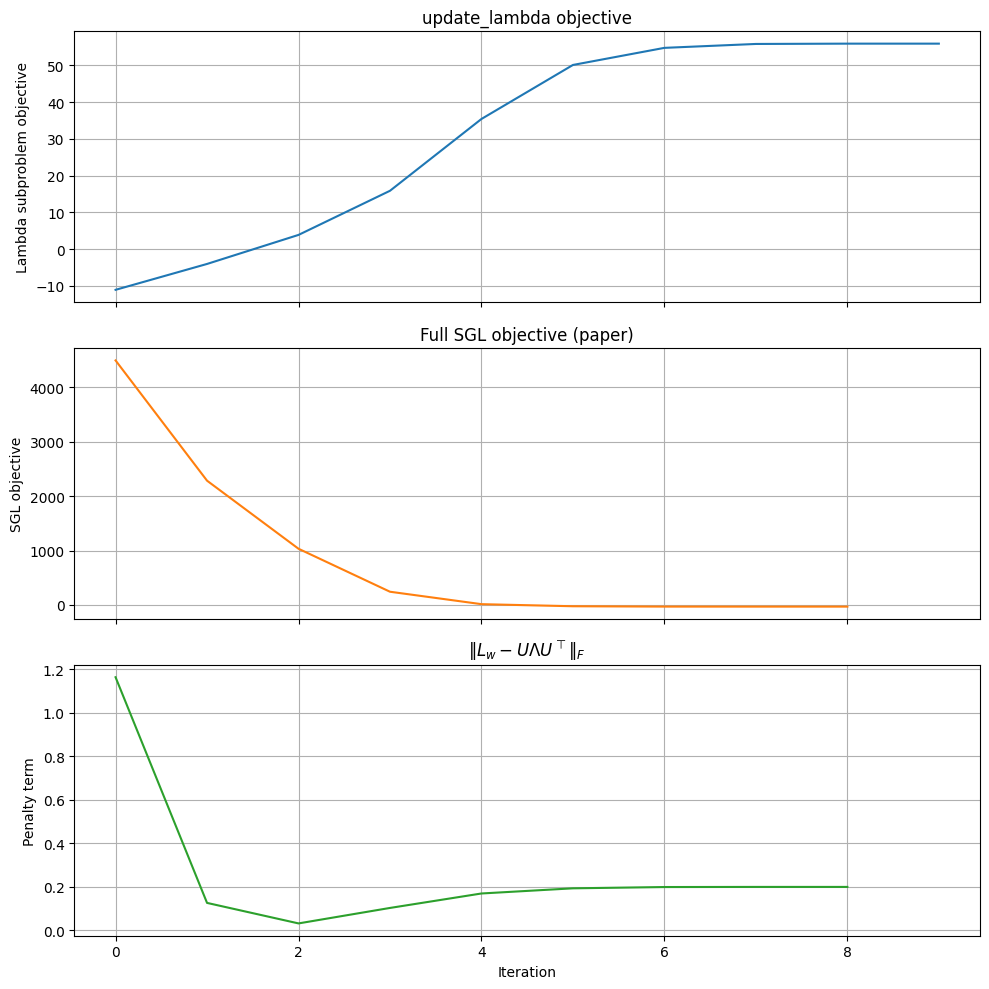

In [827]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

axs[0].plot(obj_values, color="tab:blue")
axs[0].set_ylabel("Lambda subproblem objective")
axs[0].set_title("update_lambda objective")
axs[0].grid(True)

axs[1].plot(sgl_obj, color="tab:orange")
axs[1].set_ylabel("SGL objective")
axs[1].set_title("Full SGL objective (paper)")
axs[1].grid(True)

axs[2].plot(pen_hist, color="tab:green")
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("Penalty term")
axs[2].set_title(r"$\|L_w - U \Lambda U^\top\|_F$")
axs[2].grid(True)

plt.tight_layout()
plt.show()


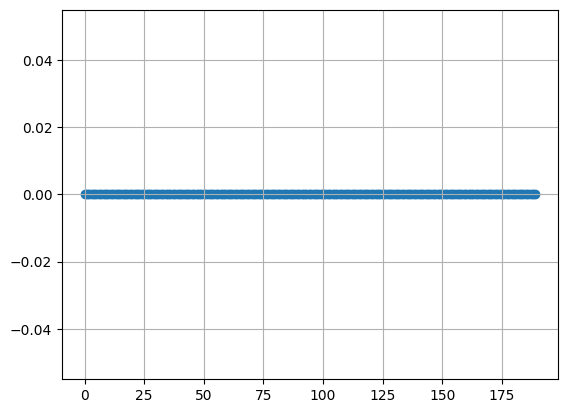

In [828]:
plt.scatter(np.arange(len(w_hat)), w_hat)
plt.grid()
plt.show()

In [829]:
edges = edge_list(p)
W_raw = np.maximum(-Theta_hat, 0.0)
np.fill_diagonal(W_raw, 0.0)

In [830]:
print("nonzero edges:", np.count_nonzero(w_hat), "/", w_hat.size)

deg = np.maximum(-Theta_hat, 0.0)
np.fill_diagonal(deg, 0.0)
deg = deg.sum(axis=1)
print("degree min/median/max:", deg.min(), np.median(deg), deg.max())
print("isolated:", np.where(deg < 1e-12)[0])


nonzero edges: 0 / 190
degree min/median/max: 0.0 0.0 0.0
isolated: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [831]:
bs = 5
within_w, between_w = [], []
for i in range(p):
    for j in range(i+1, p):
        if W_raw[i,j] > 0:
            if i//bs == j//bs:
                within_w.append(W_raw[i,j])
            else:
                between_w.append(W_raw[i,j])

print("mean weight within:", np.mean(within_w))
print("mean weight between:", np.mean(between_w))

mean weight within: nan
mean weight between: nan


/home/iliass/.local/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/iliass/.local/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [769]:
within = np.array(within_w)
between = np.array(between_w)

print("within q10/q50/q90:", np.quantile(within, [0.1, 0.5, 0.9]))
print("between q10/q50/q90:", np.quantile(between, [0.1, 0.5, 0.9]))
print("P(within > median_between):", np.mean(within > np.median(between)))


within q10/q50/q90: [0.14328906 0.171402   0.1981778 ]
between q10/q50/q90: [0.0163789  0.05158456 0.18409626]
P(within > median_between): 1.0


In [770]:
G_true = nx.from_numpy_array(W_true)
W_hat = adjacency_from_theta_knn(Theta_hat, k = 2)
G_hat = nx.from_numpy_array(W_hat)

In [771]:
print("True components (nx):", nx.number_connected_components(G_true))
print("Learned components (nx):", nx.number_connected_components(G_hat))

True components (nx): 2
Learned components (nx): 3


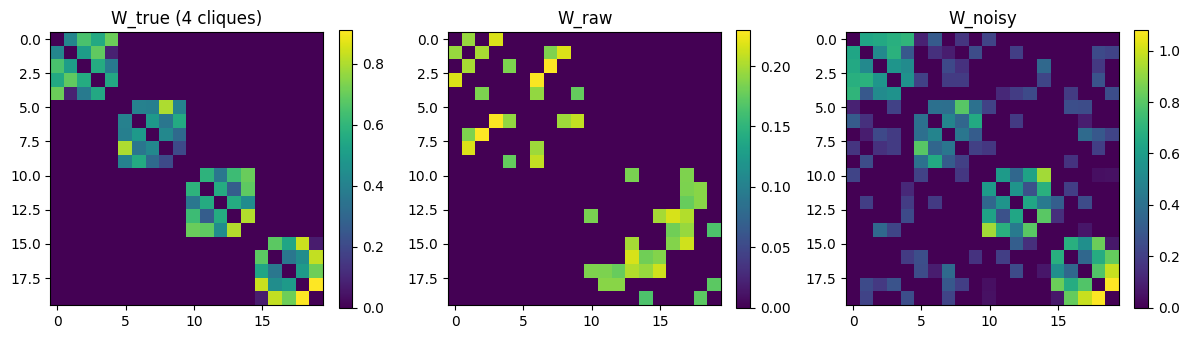

In [804]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(W_true)
plt.title("W_true (4 cliques)")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,2)
plt.imshow(W_hat)
plt.title("W_raw")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,3)
plt.imshow(W_true + W_er)
plt.title("W_noisy")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

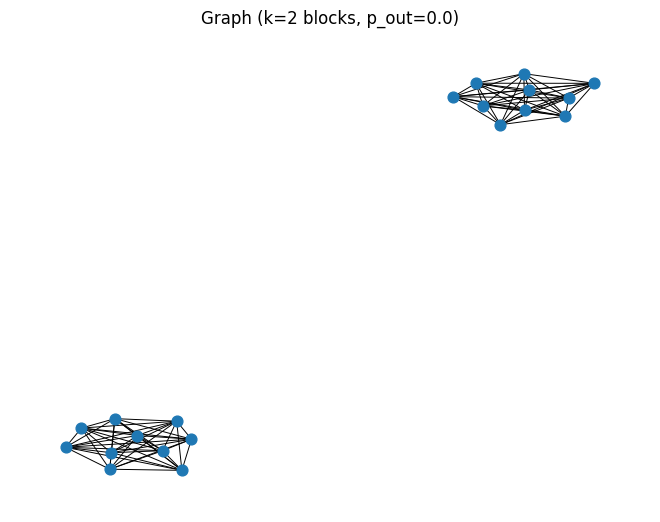

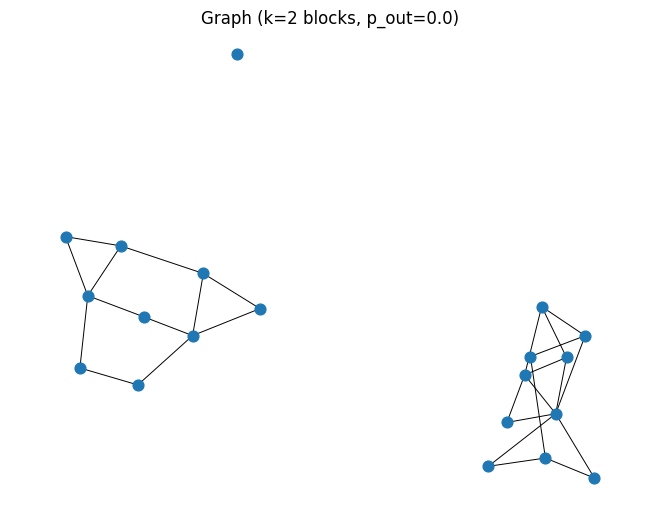

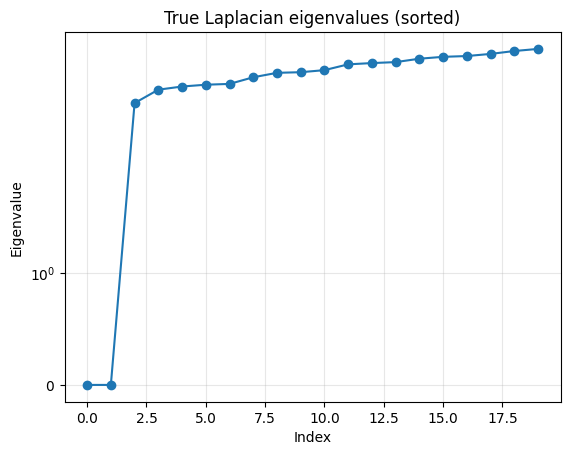

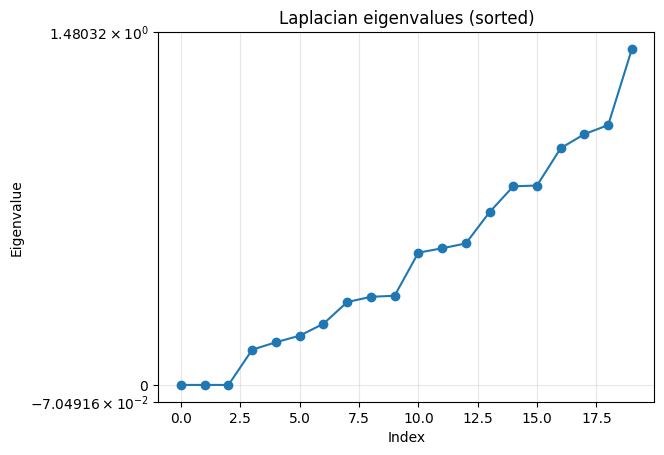

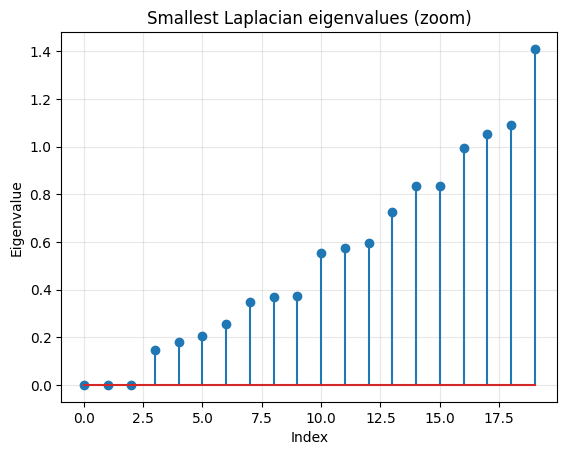

In [773]:
L_hat = laplacian_from_W(W_hat)
L_true = laplacian_from_W(W_true)
eigs_hat = np.linalg.eigvalsh(L_hat)
eigs_true = np.linalg.eigvalsh(L_true)

plt.figure()
pos = nx.spring_layout(G_true)
nx.draw(G_true, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
pos = nx.spring_layout(G_hat)
nx.draw(G_hat, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
plt.plot(eigs_true, marker="o")
plt.yscale("symlog")  
plt.title("True Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(eigs_hat, marker="o")
plt.yscale("symlog")  
plt.title("Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
m = min(25, len(eigs_hat))
plt.stem(range(m), eigs_hat[:m])
plt.title("Smallest Laplacian eigenvalues (zoom)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

In [604]:
p = 49
k_true = 7

sizes = [p // k_true] * k_true  
W_true = np.zeros((p, p), dtype=float)

start = 0
for sz in sizes:
    idx = np.arange(start, start + sz)

    A = np.ones((sz, sz), dtype=float)
    np.fill_diagonal(A, 0.0)

    W = np.random.uniform(0.0, 1.0, size=(sz, sz))
    W =  (W + W.T) / 2          
    np.fill_diagonal(W, 0.0)

    W_true[np.ix_(idx, idx)] = A * W
    start += sz

Theta_true = laplacian_from_W(W_true)

In [605]:
kappa=0.45
p_edge=1.0

M = (np.random.random((p, p)) < p_edge).astype(float)
M = np.triu(M, 1)
M = M + M.T

W_er = np.random.uniform(low = 0.0, high = kappa, size=(p, p))
W_er = (W_er + W_er.T) / 2
np.fill_diagonal(W_er, 0.0)

W_er = M * W_er
Theta_er = laplacian_from_W(W_er)

In [606]:
Theta_noisy = Theta_true + Theta_er

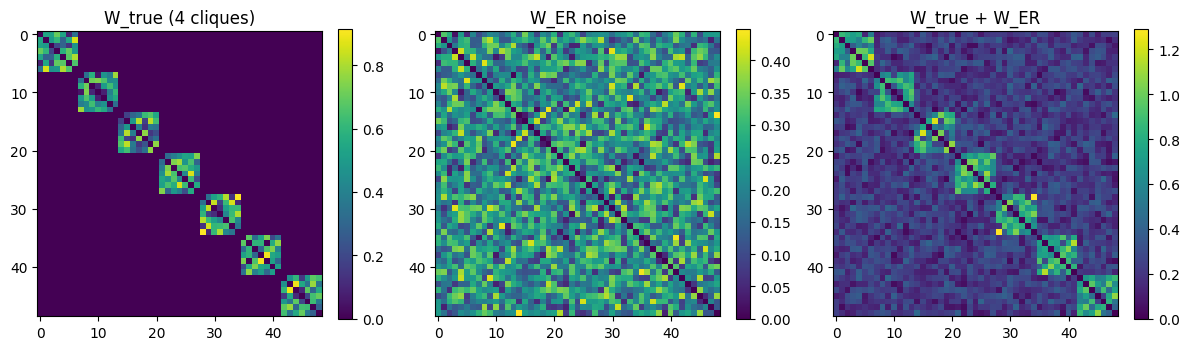

In [607]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(W_true)
plt.title("W_true (4 cliques)")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,2)
plt.imshow(W_er)
plt.title("W_ER noise")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,3)
plt.imshow(W_true + W_er)
plt.title("W_true + W_ER")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

In [608]:
n = 30 * p
J = np.ones((p, p)) / p
Sigma = np.linalg.inv(Theta_noisy + J)
X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)
S = np.cov(X, rowvar=False)
S_in = S + (1/3) * np.eye(p)

In [610]:
Theta_hat, w_hat, U_hat, lam_hat, _, _, _ = sgl(
        S=S_in,
        k=2,
        alpha=0.01,
        beta=400.0,
        eps=1e-3,
        c1=1e-5,
        c2=1e4,
        tol=1e-5,
        patience=50,
        l1 = 50.0
    )

the best relative error is: 0.002435839061209415
the relative error is: 0.002435839061209415
the relative error is: 0.0034145445543658733
the relative error is: 0.002791525118927972
the best relative error is: 0.0024220061120686642
the best relative error is: 0.0023732510311886687
the best relative error is: 0.0023254513124882094
the best relative error is: 0.0022785898068802897
the relative error is: 0.0022785898068802897
the best relative error is: 0.0022326495790620385
the best relative error is: 0.0021876139109264017
the best relative error is: 0.002143466304467357
the best relative error is: 0.0021001904842147087
the best relative error is: 0.0020577703992315866
the best relative error is: 0.002016190224705409
the best relative error is: 0.001975434363160902
the best relative error is: 0.0019354874453219825
the best relative error is: 0.001896334330647446
the best relative error is: 0.0018579601075640574
the relative error is: 0.0018579601075640574
the best relative error is: 0.00

In [611]:
G_true = nx.from_numpy_array(W_true)
W_hat = adjacency_from_theta(Theta_hat)
G_hat = nx.from_numpy_array(W_hat)

The threshold is: 0.09984666469003203


In [612]:
print("True components (nx):", nx.number_connected_components(G_true))
print("Learned components (nx):", nx.number_connected_components(G_hat))

True components (nx): 7
Learned components (nx): 16


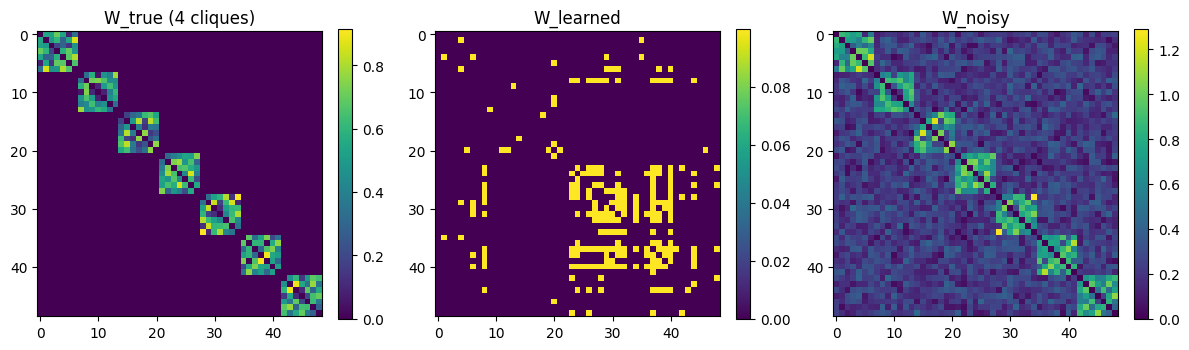

In [613]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(W_true)
plt.title("W_true (4 cliques)")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,2)
plt.imshow(W_hat)
plt.title("W_learned")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,3)
plt.imshow(W_true + W_er)
plt.title("W_noisy")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

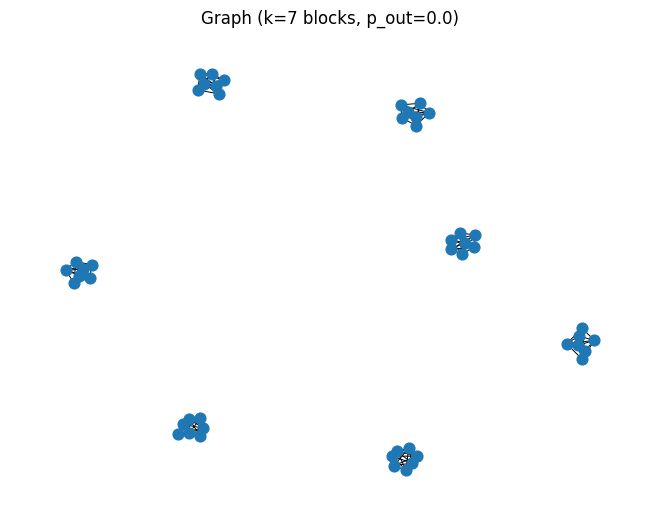

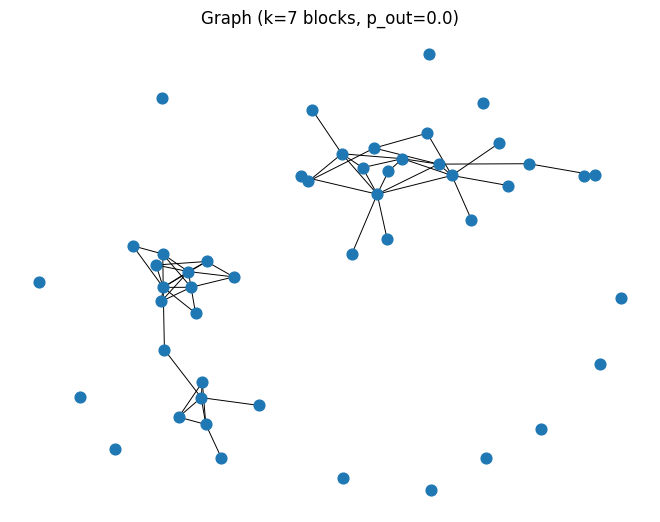

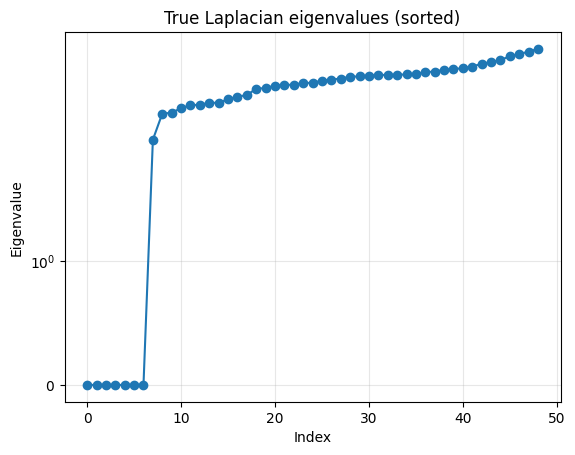

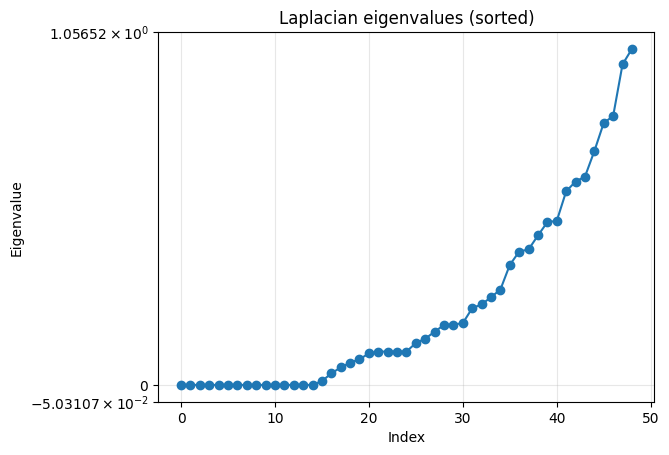

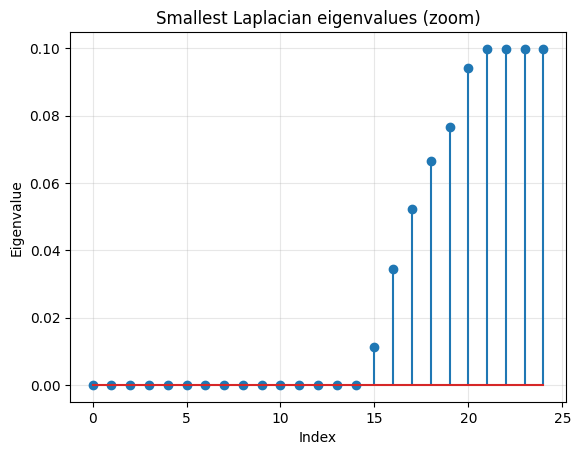

In [ ]:
L_hat = laplacian_from_W(W_hat)
L_true = laplacian_from_W(W_true)
eigs_hat = np.linalg.eigvalsh(L_hat)
eigs_true = np.linalg.eigvalsh(L_true)

plt.figure()
pos = nx.spring_layout(G_true)
nx.draw(G_true, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
pos = nx.spring_layout(G_hat)
nx.draw(G_hat, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
plt.plot(eigs_true, marker="o")
plt.yscale("symlog")  
plt.title("True Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(eigs_hat, marker="o")
plt.yscale("symlog")  
plt.title("Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
m = min(25, len(eigs_hat))
plt.stem(range(m), eigs_hat[:m])
plt.title("Smallest Laplacian eigenvalues (zoom)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

### Animal Dataset

In [ ]:
A_animals = np.loadtxt("./AwA2-base/Animals_with_Attributes2/predicate-matrix-binary.txt")  
with open("./AwA2-base/Animals_with_Attributes2/classes.txt", "r") as f:
    class_names = [line.strip() for line in f]

In [ ]:
A_animals = np.asarray(A_animals) 
print(f"The shape of the dataset is: {A_animals.shape}")

X_animals = A_animals.T
std = X_animals.std(axis=0, keepdims=True)
Xc = X_animals - X_animals.mean(axis=0, keepdims=True)

Xz = Xc / std

S_animals = (Xz.T @ Xz) / Xz.shape[0]
p = S_animals.shape[0]
S_in_animals = S_animals + (1/3) * np.eye(p)

Theta_hat_animals, w_hat, U_hat, lam_hat = sgl(
    S=S_in_animals,
    k=5,
    alpha=0.0,
    beta=0.5,
    eps=1e-3,
    c1=1e-3,
    c2=1e3,
    tol=1e-5
)

The shape of the dataset is: (50, 85)
the best relative error is: 0.4683045503407231
the relative error is: 0.4683045503407231
the best relative error is: 0.3708285022978032
the best relative error is: 0.24536157437277434
the best relative error is: 0.17211633560160805
the best relative error is: 0.12526773677641784
the best relative error is: 0.09975941383027613
the best relative error is: 0.08763100444365379
the best relative error is: 0.0749797136062992
the best relative error is: 0.0671643748447028
the relative error is: 0.0671643748447028
the best relative error is: 0.058248629100262836
the best relative error is: 0.05264535641153816
the best relative error is: 0.0460720036022552
the best relative error is: 0.042035412779278226
the best relative error is: 0.0388300556790259
the best relative error is: 0.035850654196563025
the best relative error is: 0.03420087368929725
the best relative error is: 0.03291281596117112
the best relative error is: 0.03123283852354626
the best relative

In [ ]:
W_hat_animals = adjacency_from_theta(Theta_hat_animals)
G_hat_animals = nx.from_numpy_array(W_hat_animals)

The threshold is: 0.37709519509173944


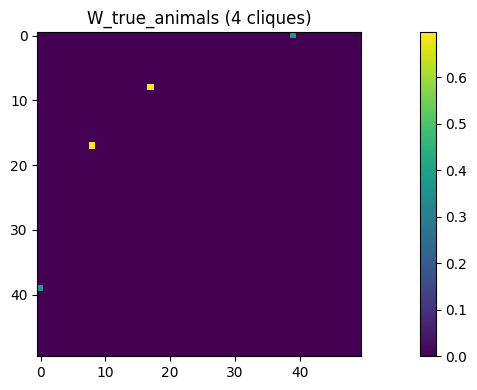

In [ ]:
plt.figure(figsize=(12,4))


plt.imshow(W_hat_animals)
plt.title("W_true_animals (4 cliques)")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

In [ ]:
print("Learned components (nx):", nx.number_connected_components(G_hat_animals))

Learned components (nx): 48


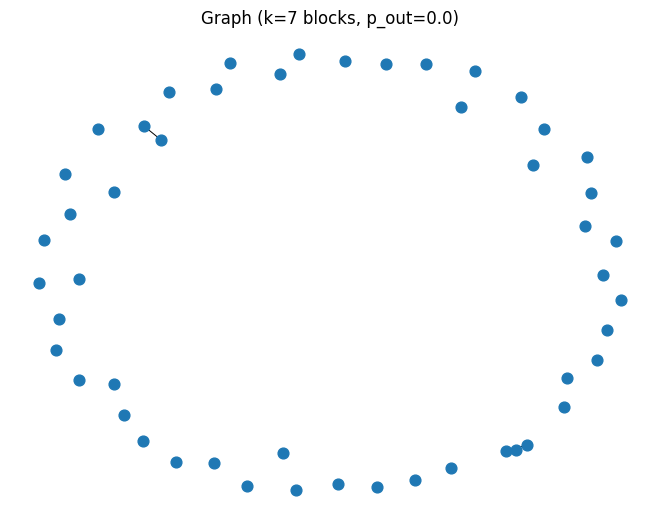

In [ ]:
plt.figure()
pos = nx.spring_layout(G_hat_animals)
nx.draw(G_hat_animals, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

### Moons, circles and clusters

In [ ]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

X_moons, labels_true_moons = make_moons(
    n_samples=100,
    noise=0.05,
    random_state=0
)


X_circles, labels_true_circles = make_circles(
    n_samples=200,
    factor=0.05,
    noise=0.05,
    random_state=0
)


def gaussian_similarity(X, sigma=None):

    D = cdist(X, X, metric="euclidean")
    
    if sigma is None:
        sigma = np.median(D[D > 0]) * 0.2

    W = np.exp(-(D * D) / (2 * (sigma*sigma)))
    np.fill_diagonal(W, 0.0)
    
    return W

def knn_sparsify(W, k):

    p = W.shape[0]
    Wk = np.zeros_like(W)
    
    for i in range(p):
        idx = np.argsort(W[i])[-k:]
        Wk[i, idx] = W[i, idx]
    
    return np.maximum(Wk, Wk.T)

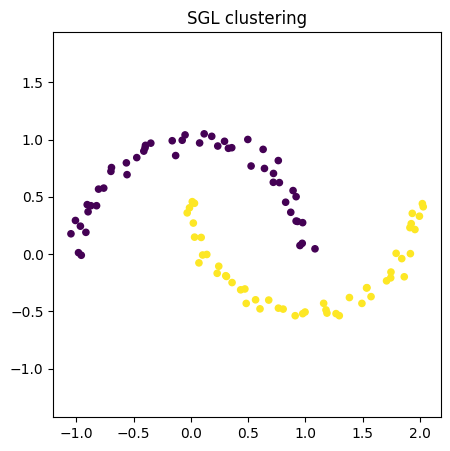

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(X_moons[:,0], X_moons[:,1], c=labels_true_moons, s=20)
plt.title("SGL clustering")
plt.axis("equal")
plt.show()

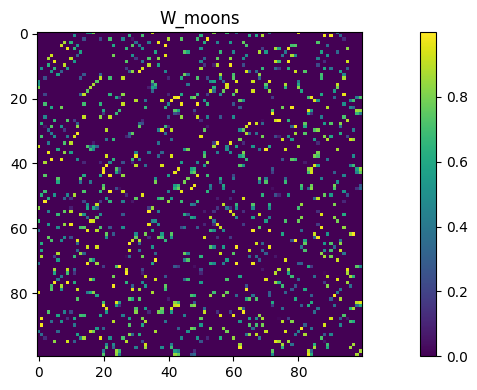

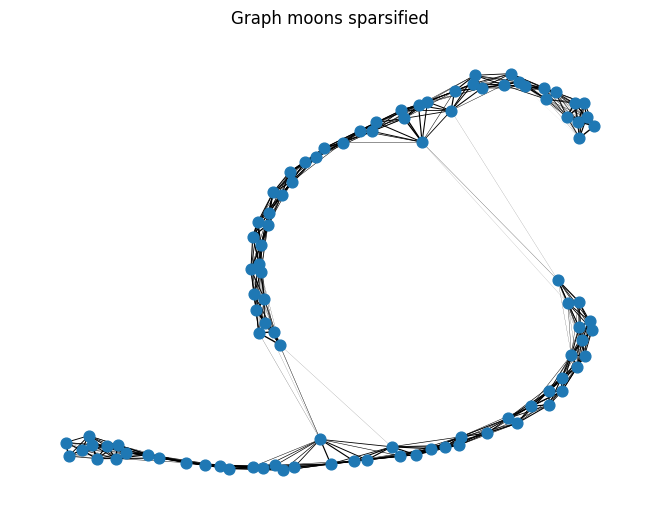

In [ ]:
W_moons = gaussian_similarity(X_moons)
W_moons = knn_sparsify(W_moons, k=10)
G_moons = nx.from_numpy_array(W_moons)

plt.figure(figsize=(12,4))


plt.imshow(W_moons)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_moons = nx.spring_layout(G_moons)
edges = list(G_moons.edges())
p = W_moons.shape[0]
weights = np.array([G_moons[u][v]["weight"] for u, v in edges])

nx.draw(G_moons, pos_moons, node_size=60, width=weights, edgelist=edges)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

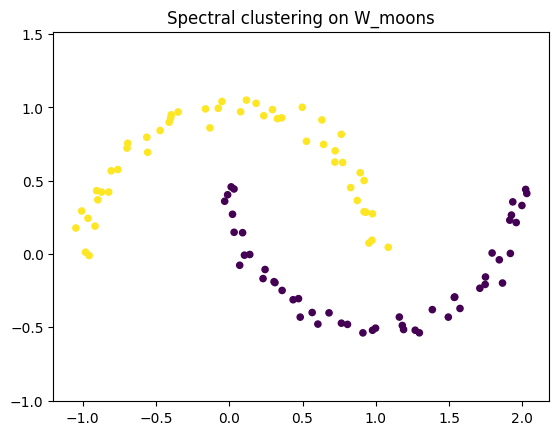

In [ ]:
from sklearn.cluster import SpectralClustering

labels_sc = SpectralClustering(
    n_clusters=2,
    affinity="precomputed",
    random_state=0
).fit_predict(W_moons)

plt.scatter(X_moons[:,0], X_moons[:,1], c=labels_sc, s=20)
plt.axis("equal")
plt.title("Spectral clustering on W_moons")
plt.show()

In [ ]:
p = W_moons.shape[0]
S_moons = W_moons + (1/3) * np.eye(p)

Theta_hat_moons, w_hat_moons, U_hat_moons, lam_hat_mooons = sgl(
    S=S_moons,
    k=2,
    alpha=0.0,     
    beta=100.0,
    eps=1e-3,
    c1=1e-5,
    c2=1e5,
    tol=1e-5,
    patience=50,
    l1 = 50.0,
)

the best relative error is: 0.0014721721911418154
the relative error is: 0.0014721721911418154
the relative error is: 0.0023642198050981365
the relative error is: 0.0019323377556945223
the relative error is: 0.0015781448814437043
the best relative error is: 0.001455143442562301
the best relative error is: 0.0014259054396101559
the best relative error is: 0.0013972492113550337
the best relative error is: 0.0013691635239515096
the best relative error is: 0.0013416373402606618
the best relative error is: 0.001314659817633957
the best relative error is: 0.0012882203056409024
the relative error is: 0.0012882203056409024
the best relative error is: 0.0012623083437472706
the best relative error is: 0.0012369136589503206
the best relative error is: 0.0012120261633770117
the best relative error is: 0.0011876359518507406
the best relative error is: 0.0011637332994318078
the best relative error is: 0.0011403086589364066
the best relative error is: 0.0011173526584386665
the best relative error is:

In [ ]:
W_hat_moons = adjacency_from_theta(Theta_hat_moons)
G_hat_moons = nx.from_numpy_array(W_hat_moons)

The threshold is: 0.10093230319800801


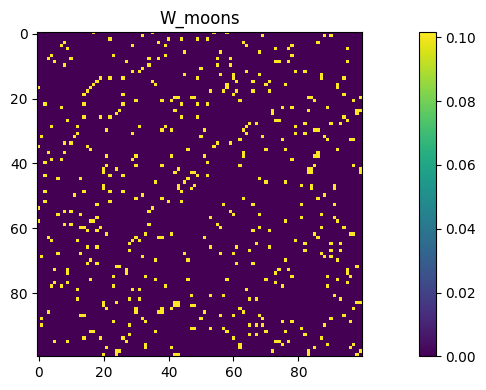

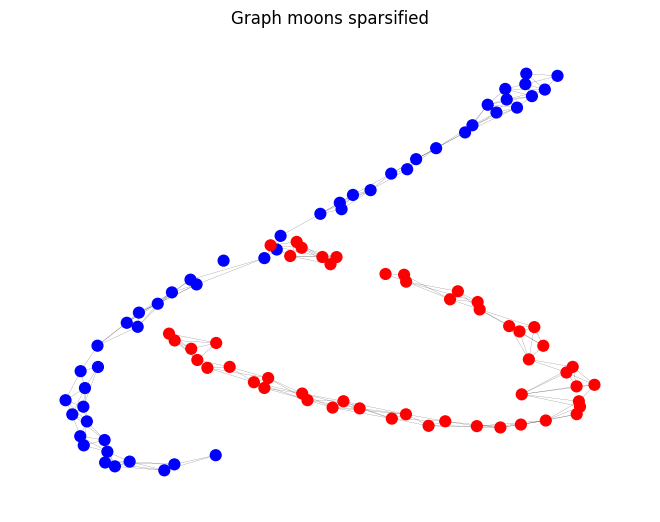

In [ ]:
color_map = list()
for label in labels_true_moons:
    if label == 1:
        color_map.append('red')
    else :
        color_map.append('blue')

color_map = np.array(color_map)

plt.figure(figsize=(12,4))

plt.imshow(W_hat_moons)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_moons = nx.spring_layout(G_moons)
edges = list(G_hat_moons.edges())
p = W_hat_moons.shape[0]
weights = np.array([G_hat_moons[u][v]["weight"] for u, v in edges])

nx.draw(G_hat_moons, pos_moons, node_size=60, width=weights, edgelist=edges, node_color=color_map)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

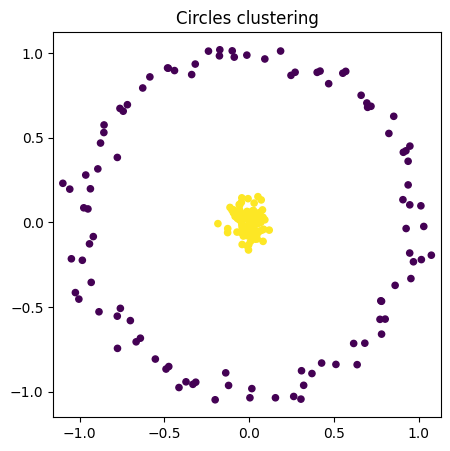

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(X_circles[:,0], X_circles[:,1], c=labels_true_circles, s=20)
plt.title("Circles clustering")
plt.axis("equal")
plt.show()

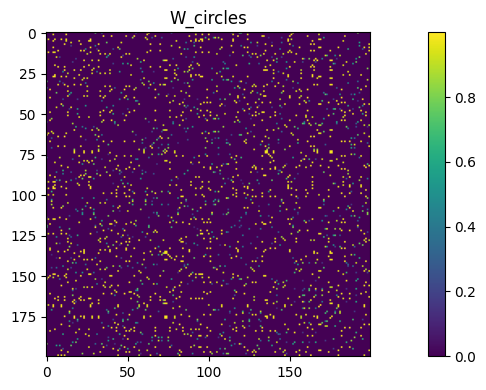

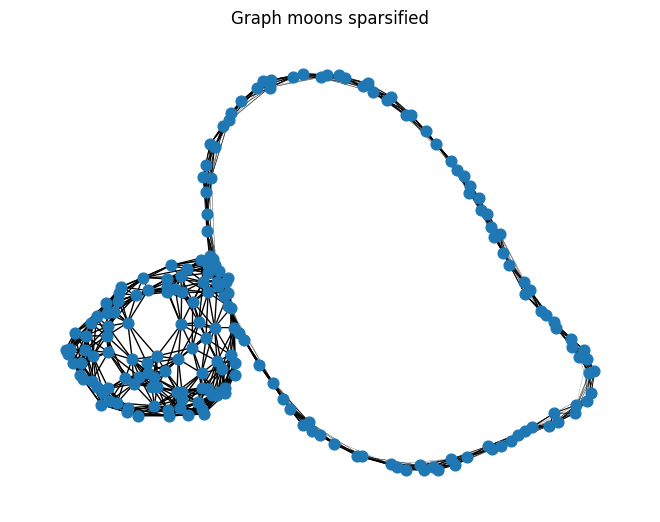

In [ ]:
W_circles = gaussian_similarity(X_circles)
W_circles = knn_sparsify(W_circles, k=10)
G_circles = nx.from_numpy_array(W_circles)

plt.figure(figsize=(12,4))


plt.imshow(W_circles)
plt.title("W_circles")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_circles = nx.spring_layout(G_circles)
edges_circles = list(G_circles.edges())
p = W_circles.shape[0]
weights_circles = np.array([G_circles[u][v]["weight"] for u, v in edges_circles])

nx.draw(G_circles, pos_circles, node_size=60, width=weights_circles, edgelist=edges_circles)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

In [ ]:
p = W_circles.shape[0]
S_circles = W_circles + (1/3) * np.eye(p)

Theta_hat_circles, w_hat_circles, U_hat_circles, lam_hat_circles = sgl(
    S=S_circles,
    k=2,
    alpha=0.0,     
    beta=100.0,
    eps=1e-3,
    c1=1e-5,
    c2=1e5,
    tol=1e-5,
    patience=50,
    l1 = 50.0,
)

the best relative error is: 0.001295722693988751
the relative error is: 0.001295722693988751
the relative error is: 0.0016562639154744621
the relative error is: 0.0013535037961760921
the best relative error is: 0.001273866010542486
the best relative error is: 0.001248366903985152
the best relative error is: 0.0012233743652738448
the best relative error is: 0.0011988785596326282
the best relative error is: 0.0011748698297354043
the best relative error is: 0.0011513386933178957
the best relative error is: 0.0011282758407688465
the best relative error is: 0.0011056721327050156
the relative error is: 0.0011056721327050156
the best relative error is: 0.0010835185975341646
the best relative error is: 0.0010618064290098433
the best relative error is: 0.0010405269837815072
the best relative error is: 0.0010196717789432042
the best relative error is: 0.000999232489583774
the best relative error is: 0.000979200946341321
the best relative error is: 0.0009595691329644639
the best relative error is

In [ ]:
W_hat_circles = adjacency_from_theta(Theta_hat_circles)
G_hat_circles = nx.from_numpy_array(W_hat_circles)

The threshold is: 0.1000341405339621


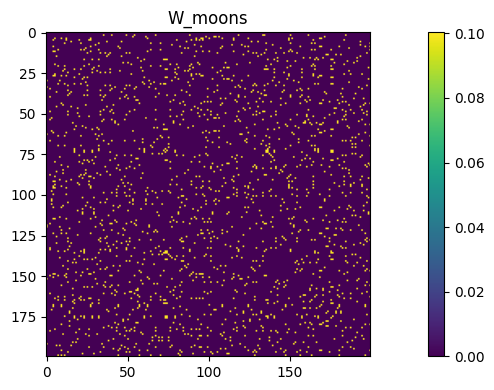

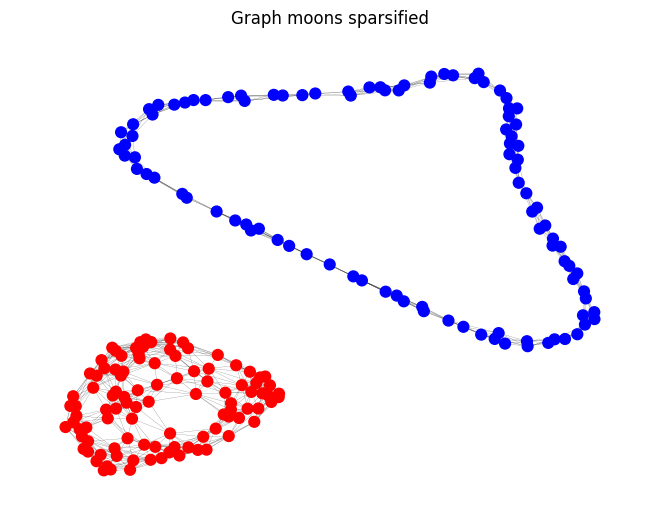

In [ ]:
color_map = list()
for label in labels_true_circles:
    if label == 1:
        color_map.append('red')
    else :
        color_map.append('blue')

color_map = np.array(color_map)

plt.figure(figsize=(12,4))

plt.imshow(W_hat_circles)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_circles = nx.spring_layout(G_circles)
edges_circles = list(G_hat_circles.edges())
p = W_hat_circles.shape[0]
weights_circles = np.array([G_hat_circles[u][v]["weight"] for u, v in edges_circles])

nx.draw(G_hat_circles, pos_circles, node_size=60, width=weights_circles, edgelist=edges_circles, node_color=color_map)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

### SGA Algorithm

In [ ]:
def laplacian_from_W(W: np.ndarray):
    D = np.diag(W.sum(axis=1))
    return D - W

def count_components_from_eigs(eigs, tol=1e-8):
    return int(np.sum(eigs < tol))

Adjacency algorithm

In [ ]:
def A_operator(w: np.ndarray, p: int, edges=None):
    """
    Adjacency operator A : w -> W = Aw
    Off-diagonal: W_ij = w_k, diag = 0 (See page 19)
    """

    if edges is None:
        edges = edge_list(p)
        
    W = np.zeros((p, p), dtype=float)
    
    for wk, (i, j) in zip(w, edges):

        W[i, j] = wk
        W[j, i] = wk
    
    np.fill_diagonal(W, 0.0)

    return W

def A_adjoint(Y: np.ndarray, p: int, edges=None):
    """
    Adjoint A* : Y -> vector where each entry is Y_ij + Y_ji (See paper page 19)
    """

    if edges is None:
        edges = edge_list(p)

    out = np.zeros(len(edges), dtype=float)
    
    for k, (i, j) in enumerate(edges):
        out[k] = Y[i, j] + Y[j, i]
    
    return out

Testing the correctness of the adjacency operator.

In [ ]:
p = 4
edges = edge_list(p)

m = p*(p-1)//2
w = np.arange(1, m+1)
A = A_operator(w, p, edges)
Y = np.random.randn(p, p)

left = np.sum(A * Y)  
right = np.dot(w, A_adjoint(Y, p, edges))
print("adjoint error:", np.isclose(left - right, 0), np.abs(left - right))

adjoint error: True 0.0


In [ ]:
def V_from_Aw(Aw: np.ndarray, z: int):
        
        _, evecs = np.linalg.eigh(Aw)  
        a = (p - z) // 2
        b = (p + z) // 2
        
        V = np.concatenate([evecs[:, :a], evecs[:, b:]], axis=1)
        return V

In [ ]:
def update_psi_with_update_lambda(e, c1, c2, beta_lam):

        """
        Adaptation of the lambda Algo
        """

        e = np.asarray(e, float)
        b = e.size
        assert b % 2 == 0
        half = b // 2

        
        t = (e[:half] - e[::-1][:half]) / 2
        
        t_proj_inc = update_lambda(-t, beta=beta_lam, c1=-c1, c2=-c2)
        t_proj = -t_proj_inc

        psi = np.concatenate([t_proj, -t_proj[::-1]])
        return psi

In [ ]:
def sga(S: np.ndarray,
        alpha: float = 1e-3,
        gamma: float = 10.0,          
        beta: float = 50.0,       
        eps: float = 1e-5,
        c1: float = 1.0,              
        c2: float = 0.1,              
        z: int = 0,                   
        w0: np.ndarray | None = None,
        tol: float = 1e-5):      

    """
    SGA Algporithm

    Inputs (match paper):
      - S: sample covariance matrix (SCM)
      - k: number of connected components (k>=1), so q = p-k non-zero eigenvalues
      - c1, c2: bounds for non-zero Laplacian eigenvalues
      - beta: penalty parameter in relaxation
      - alpha: sparsity weight for reweighted l1 via log(eps + w_i)
      - eps: small positive number in log(eps + w_i)
      - w0: initialization for edge weights (nonnegative), length p(p-1)/2
      - stopping: relative change in w

    Returns:
      Theta: learned Laplacian matrix (p x p)
      w, U, lam: final iterates
    """       

    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    assert S.shape == (p, p)

    edges = edge_list(p)
    m = len(edges)

    if w0 is None:
        w = 0.1 * np.ones(m, dtype=float)
    else:
        w = np.maximum(np.asarray(w0, dtype=float).copy(), 0.0)

    J = np.ones((p, p), dtype=float) / p
    L = 2.0 * p
   
    Aw = A_operator(w, p, edges)
    

    V = V_from_Aw(Aw, z=z)
    
    e = np.diag(V.T @ Aw @ V).copy()

    psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)

    while True:

        w_old = w.copy()

        Lmat = L_operator(w, p, edges)
        Aw = A_operator(w, p, edges)
        
        M = Lmat + J
        Minv = np.linalg.inv(M)
        grad_f1 = - (1.0 / gamma) * L_adjoint(Minv, p, edges)

        
        c_tilde = A_adjoint((V * psi) @ V.T, p, edges) - (1.0 / gamma) * L_adjoint(S, p, edges)
        grad_f2 = A_adjoint(Aw, p, edges) - c_tilde

        
        grad_f3 = (alpha / gamma) * (1.0 / (eps + w))

        grad = grad_f1 + grad_f2 + grad_f3
        w = np.maximum(w - (grad / L), 0.0)

        Aw = A_operator(w, p, edges)
        V = V_from_Aw(Aw, z=z)
 
        e = np.diag(V.T @ Aw @ V).copy()
        psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)

        if np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12) < tol:
            break


    Theta_hat = L_operator(w, p, edges)
    return Theta_hat, w, V, psi

### SGLA Algorithm

In [ ]:
def sgla(S: np.ndarray,
        k : int,
        alpha: float = 1e-3,
        gamma: float = 10.0,          
        beta: float = 50.0,       
        eps: float = 1e-5,
        c1: float = 1.0,              
        c2: float = 0.1,              
        z: int = 0,                   
        w0: np.ndarray | None = None,
        tol: float = 1e-5):      

    """
    SGA Algporithm

    Inputs (match paper):
      - S: sample covariance matrix (SCM)
      - k: number of connected components (k>=1), so q = p-k non-zero eigenvalues
      - c1, c2: bounds for non-zero Laplacian eigenvalues
      - beta: penalty parameter in relaxation
      - alpha: sparsity weight for reweighted l1 via log(eps + w_i)
      - eps: small positive number in log(eps + w_i)
      - w0: initialization for edge weights (nonnegative), length p(p-1)/2
      - stopping: relative change in w

    Returns:
      Theta: learned Laplacian matrix (p x p)
      w, U, lam: final iterates
    """       

    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    assert S.shape == (p, p)

    edges = edge_list(p)
    m = len(edges)

    if w0 is None:
        w = 0.1 * np.ones(m, dtype=float)
    else:
        w = np.maximum(np.asarray(w0, dtype=float).copy(), 0.0)

    J = np.ones((p, p), dtype=float) / p
    L = 2 * (p * beta + gamma)

    Aw = A_operator(w, p, edges)
    Lw = L_operator(w, p, edges)

    V = V_from_Aw(Aw, z=z)
    _, U = np.linalg.eigh(Lw)
    U = U[:, k :]
    
    e = np.diag(V.T @ Aw @ V).copy()
    d = np.diag(U.T @ Lw @ U).copy()

    psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)
    lam = update_lambda(d, c1 = c1, c2 = c2, beta=beta)

    while True:

        w_old = w.copy()

        Lw = L_operator(w, p, edges)
        Aw = A_operator(w, p, edges)
        
        c_1 = beta * L_adjoint((U * lam) @ U.T - S / beta, p = p, edges=edges)
        c_2 = gamma * A_adjoint((V * psi) @ V.T, p = p, edges = edges)
        b_1 = alpha / (eps + w)

        grad_f1 = beta * L_adjoint(Lw, p = p, edges=edges) - c_1 + b_1
        grad_f2 = gamma * A_adjoint(Aw, p = p, edges = edges) - c_2

        grad = grad_f1 + grad_f2 
        w = np.maximum(w - (grad / L), 0.0)

        Aw = A_operator(w, p, edges)
        V = V_from_Aw(Aw, z=z)
        _, U = np.linalg.eigh(Lw)
        U = U[:, k :]

        d = np.diag(U.T @ Lw @ U).copy()
        e = np.diag(V.T @ Aw @ V).copy()
        psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)
        lam = update_lambda(d, c1 = c1, c2 = c2, beta = beta)

        if np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12) < tol:
            break

    Theta_hat = L_operator(w, p, edges)
    return Theta_hat, w, V, psi